# RTC System Data
## Import Libraries

In [1]:
# Upgrade command
!pip install --upgrade pip

# Install Requests
!pip install requests

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1.1)


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
import json
import requests
import datetime
import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from collections import namedtuple
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.pyplot import figure

### Latitude, Longitude & TZ

In [3]:
# Specify Location (Albuquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

## Accessing API with Pandas
### Weather and System Data

In [4]:
# Get Weather Data from URL - June 18
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/weather/start/2020-06-16/end/2020-06-17/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
weather_df = pd.DataFrame(response.json())
weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,RainDailyAccumilation,RelativeHumidity,TmStamp,WindDirection,WindSpeed
0,21.980000,-6.933141,0.043442,-6.244432,0.0,43.259998,1592265660000,51.509998,1.915
1,21.980000,-7.799762,-0.051866,-6.279969,0.0,43.110001,1592265720000,59.709999,1.852
2,21.940001,-6.344629,0.114857,-6.293627,0.0,42.880001,1592265780000,60.230000,1.877
3,21.910000,-6.760925,-0.008000,-6.270234,0.0,42.689999,1592265840000,65.230003,1.909
4,21.920000,-7.252959,-0.056925,-6.185312,0.0,42.689999,1592265900000,59.330002,1.907


In [5]:
# Drop unnecessary data
weather_df.drop(['RainDailyAccumilation', 'RelativeHumidity', 'WindDirection', 'WindSpeed'], axis=1, inplace=True)

weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,TmStamp
0,21.980000,-6.933141,0.043442,-6.244432,1592265660000
1,21.980000,-7.799762,-0.051866,-6.279969,1592265720000
2,21.940001,-6.344629,0.114857,-6.293627,1592265780000
3,21.910000,-6.760925,-0.008000,-6.270234,1592265840000
4,21.920000,-7.252959,-0.056925,-6.185312,1592265900000


In [6]:
weather_df.rename(columns={'TmStamp':'TimeStamp', 'GlobalIrrad':'GHI', 'DirectIrrad':'DNI', 'DiffuseIrrad':'DHI'}, inplace=True)

In [7]:
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,21.980000,-6.933141,0.043442,-6.244432,1592265660000
1,21.980000,-7.799762,-0.051866,-6.279969,1592265720000
2,21.940001,-6.344629,0.114857,-6.293627,1592265780000
3,21.910000,-6.760925,-0.008000,-6.270234,1592265840000
4,21.920000,-7.252959,-0.056925,-6.185312,1592265900000


In [8]:
# Examine the types of the column labels
all(isinstance(column, str) for column in weather_df.columns)

True

In [9]:
weather_df['TimeStamp'] =  pd.to_datetime(weather_df['TimeStamp']/1000, unit='s')
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,21.980000,-6.933141,0.043442,-6.244432,2020-06-16 00:01:00
1,21.980000,-7.799762,-0.051866,-6.279969,2020-06-16 00:02:00
2,21.940001,-6.344629,0.114857,-6.293627,2020-06-16 00:03:00
3,21.910000,-6.760925,-0.008000,-6.270234,2020-06-16 00:04:00
4,21.920000,-7.252959,-0.056925,-6.185312,2020-06-16 00:05:00


In [10]:
# TimeStamp as Index
weather_df.set_index('TimeStamp', inplace=True)
weather_df.head()

,AmbientTemp,DHI,DNI,GHI
TimeStamp,,,,
2020-06-16 00:01:00,21.980000,-6.933141,0.043442,-6.244432
2020-06-16 00:02:00,21.980000,-7.799762,-0.051866,-6.279969
2020-06-16 00:03:00,21.940001,-6.344629,0.114857,-6.293627
2020-06-16 00:04:00,21.910000,-6.760925,-0.008000,-6.270234
2020-06-16 00:05:00,21.920000,-7.252959,-0.056925,-6.185312


In [11]:
# Weather Keys
print("Keys of weather_df: \n{}".format(weather_df.keys()))

Keys of weather_df: 
Index(['AmbientTemp', 'DHI', 'DNI', 'GHI'], dtype='object')


In [12]:
# Analyzing Data - June 17
# Global Horizonal & Direct Normal(W/m*2)
# Air Temperature (deg C)
weather_df.describe()

,AmbientTemp,DHI,DNI,GHI
count,1439.000000,1439.000000,1439.000000,1439.000000
mean,26.366769,55.993353,395.744664,324.464887
std,4.322259,79.636971,417.910140,385.016017
min,18.870001,-10.181525,-0.280523,-7.179403
25%,21.969999,-5.720989,0.186166,-5.909561
50%,27.150000,43.856033,167.961914,170.818497
75%,30.260000,72.108707,859.040039,625.090851
max,32.820000,365.542603,978.783875,1139.239502


In [13]:
weather_df_slice = weather_df.iloc[::5] 

## System

In [14]:
# Get System Data from URL - June 17
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/system/start/2020-06-16/end/2020-06-17/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
system_df = pd.DataFrame(response.json())
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TmStamp
0,20.949999,-1.158749,0.0,0.0,-0.045,2.200000,-2.497435,0.006,1.616667,0.0,1592265660000
1,21.049999,-1.158749,0.0,0.0,-0.045,2.250000,-2.423445,0.006,1.666667,0.0,1592265720000
2,21.133333,-1.158749,0.0,0.0,-0.045,2.233333,-2.422840,0.006,1.683333,0.0,1592265780000
3,21.200001,-1.158749,0.0,0.0,-0.045,2.200000,-2.349858,0.006,1.700000,0.0,1592265840000
4,21.216667,-1.158749,0.0,0.0,-0.045,2.200000,-2.570171,0.006,1.633333,0.0,1592265900000


In [15]:
# System Keys
print("Keys of system_df: \n{}".format(system_df.keys()))

Keys of system_df: 
Index(['AmbientTemp', 'PyranometerIrrad', 'RefCell1Irrad', 'RefCell2Irrad',
       'Sys1Idc', 'Sys1Vdc', 'Sys1Wac', 'Sys2Idc', 'Sys2Vdc', 'Sys2Wac',
       'TmStamp'],
      dtype='object')


In [16]:
system_df.rename(columns={'TmStamp':'TimeStamp'}, inplace=True)

In [17]:
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,20.949999,-1.158749,0.0,0.0,-0.045,2.200000,-2.497435,0.006,1.616667,0.0,1592265660000
1,21.049999,-1.158749,0.0,0.0,-0.045,2.250000,-2.423445,0.006,1.666667,0.0,1592265720000
2,21.133333,-1.158749,0.0,0.0,-0.045,2.233333,-2.422840,0.006,1.683333,0.0,1592265780000
3,21.200001,-1.158749,0.0,0.0,-0.045,2.200000,-2.349858,0.006,1.700000,0.0,1592265840000
4,21.216667,-1.158749,0.0,0.0,-0.045,2.200000,-2.570171,0.006,1.633333,0.0,1592265900000


In [18]:
# Examine the types of the column labels
all(isinstance(column, str) for column in system_df.columns)

True

In [19]:
system_df['TimeStamp'] =  pd.to_datetime(system_df['TimeStamp']/1000, unit='s')
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,20.949999,-1.158749,0.0,0.0,-0.045,2.200000,-2.497435,0.006,1.616667,0.0,2020-06-16 00:01:00
1,21.049999,-1.158749,0.0,0.0,-0.045,2.250000,-2.423445,0.006,1.666667,0.0,2020-06-16 00:02:00
2,21.133333,-1.158749,0.0,0.0,-0.045,2.233333,-2.422840,0.006,1.683333,0.0,2020-06-16 00:03:00
3,21.200001,-1.158749,0.0,0.0,-0.045,2.200000,-2.349858,0.006,1.700000,0.0,2020-06-16 00:04:00
4,21.216667,-1.158749,0.0,0.0,-0.045,2.200000,-2.570171,0.006,1.633333,0.0,2020-06-16 00:05:00


In [20]:
system_df.drop(system_df.index[range(0, 360)], axis=0, inplace=True)

In [21]:
system_df.drop(system_df.index[range(1019, 1079)], axis=0, inplace=True)

In [22]:
# TimeStamp as Index
system_df.set_index('TimeStamp', inplace=True)
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-16 06:01:00,21.875000,46.349934,36.770126,35.734722,0.26350,328.133331,73.055222,0.2995,351.333344,79.643280
2020-06-16 06:02:00,22.033333,46.156811,37.058838,36.013279,0.26725,326.316681,73.867241,0.2905,359.133301,83.097542
2020-06-16 06:03:00,21.924997,44.611816,37.346973,36.321003,0.27075,325.699982,74.757332,0.2975,356.800018,83.698372
2020-06-16 06:04:00,21.974998,42.390881,37.681122,36.614128,0.27325,326.300018,76.066582,0.3010,356.516693,85.235359
2020-06-16 06:05:00,22.008331,41.425259,37.955151,36.921814,0.27700,326.466644,77.403648,0.3035,356.633331,86.199165


In [23]:
# Analyzing Data
system_df.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000
mean,27.807343,399.140712,386.235420,383.634803,3.161148,268.254410,985.520690,3.187619,268.791783,1015.036519
std,2.739870,376.748550,373.629712,373.802589,3.085076,131.172274,935.617905,3.058200,136.518022,951.950247
min,21.875000,-3.572808,0.000000,0.000000,-0.042250,2.400000,-2.864847,0.006000,1.566667,0.000000
25%,25.708334,24.092312,25.406854,25.049642,0.167125,303.158325,30.904750,0.195750,314.291672,41.213705
50%,28.424997,283.989960,250.643005,247.234085,2.020500,322.716644,670.353333,2.037500,327.299988,694.514893
75%,30.100000,787.804108,782.175018,773.120422,6.426625,344.258316,2028.598572,6.426750,351.216644,2069.672241
max,33.641666,1087.099243,1064.985229,1071.043091,8.778250,403.566650,2634.944824,8.678250,371.433319,2704.567139


In [24]:
system_df_slice = system_df.iloc[::5] 

In [25]:
system_df_slice.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-16 06:01:00,21.875000,46.349934,36.770126,35.734722,0.2635,328.133331,73.055222,0.29950,351.333344,79.643280
2020-06-16 06:06:00,22.183332,40.556198,38.319809,37.258770,0.2790,328.666656,77.926704,0.30325,358.733307,86.870537
2020-06-16 06:11:00,22.133333,42.487446,40.634830,38.719505,0.3005,335.416656,87.642815,0.32725,361.166656,95.407135
2020-06-16 06:16:00,22.816666,55.813049,47.534805,43.554813,0.3240,347.883301,99.678986,0.37150,363.933319,112.873894
2020-06-16 06:21:00,22.616667,78.601768,44.138714,44.348064,0.3480,356.416656,110.325600,0.43075,366.116669,134.243179


In [26]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,27.803349,399.397123,386.491875,383.854924,3.161621,268.481366,984.818097,3.190942,269.548196,1015.128679
std,2.744528,377.511822,374.593154,374.796527,3.090203,131.021759,936.816413,3.068544,136.372314,953.934535
min,21.875000,-3.476246,0.000000,0.000000,-0.042250,2.400000,-2.790799,0.006000,1.566667,0.000000
25%,25.727082,25.782153,26.557075,26.196659,0.178062,303.762497,34.986243,0.204875,314.662476,44.707595
50%,28.470832,283.700256,247.262497,241.237556,1.990750,322.333328,663.879181,2.008750,327.424988,688.765564
75%,30.102084,776.578751,771.347763,762.022888,6.332062,343.966660,2005.553131,6.349687,351.354172,2043.402527
max,32.500000,1083.816040,1060.982300,1066.247314,8.636500,398.549957,2622.957764,8.674000,370.633331,2682.318848


# Weather and System Plot
## Weather June 16

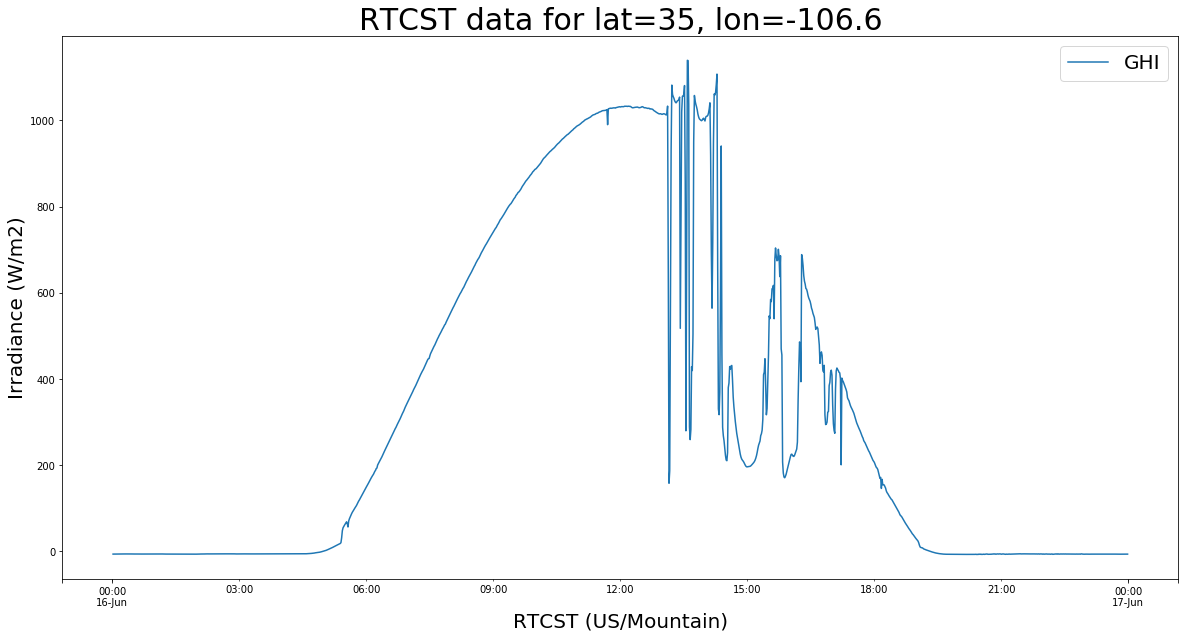

In [27]:
# Plot GHI
irrad_var = ['GHI']
weather_df[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

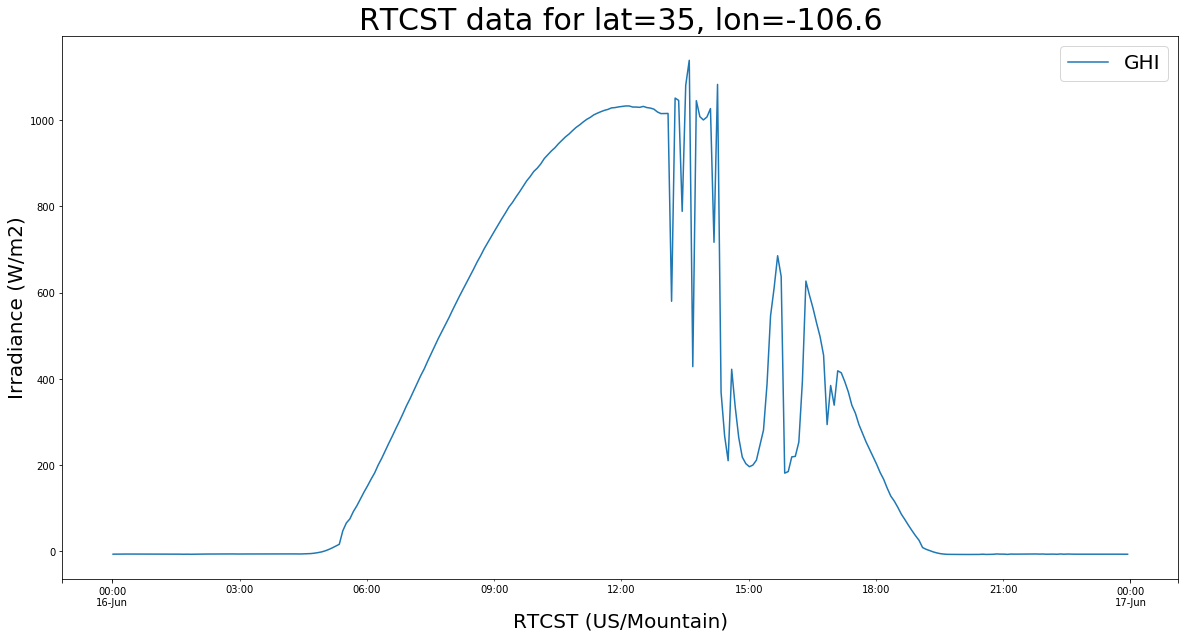

In [28]:
# Plot GHI
irrad_var = ['GHI']
weather_df_slice[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## System PIV June 16

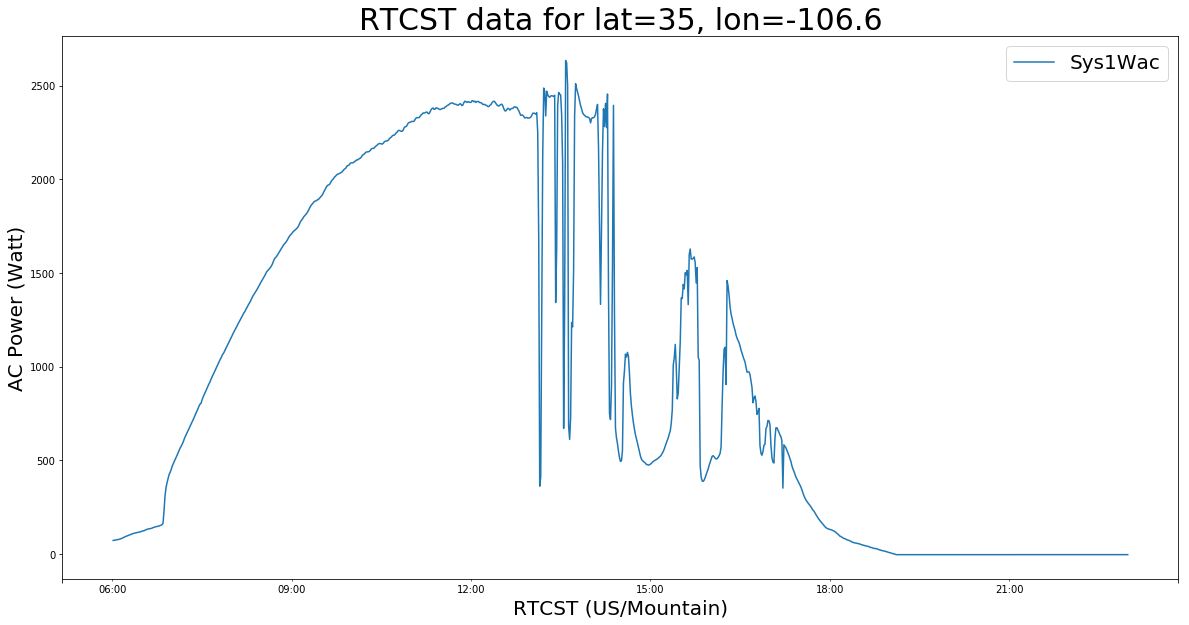

In [29]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

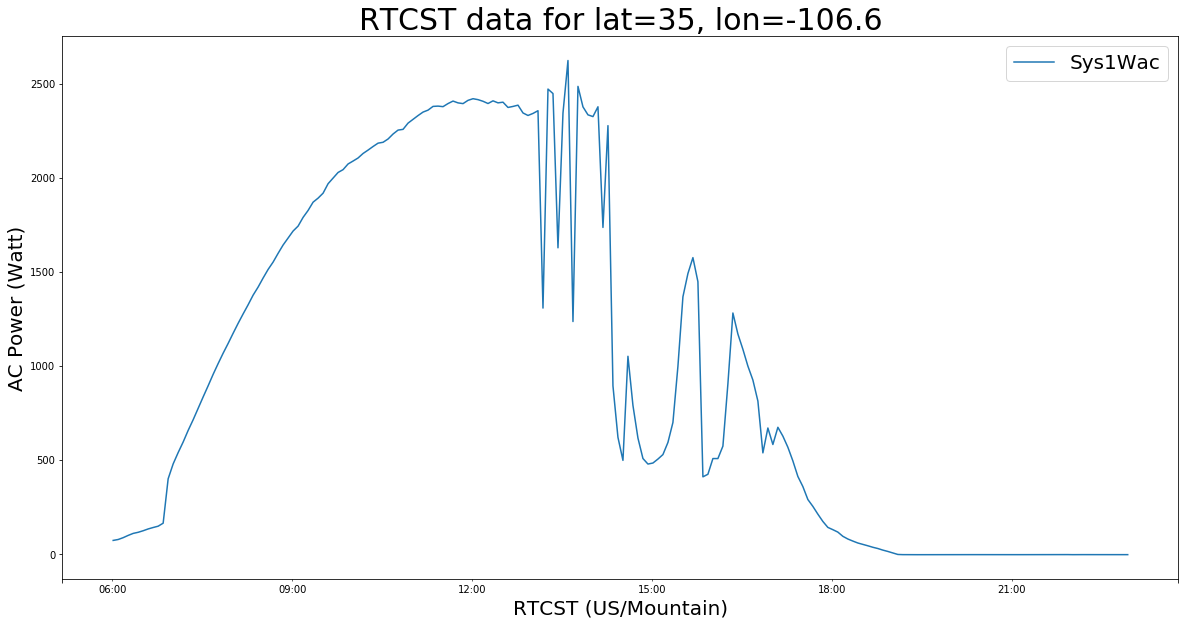

In [30]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

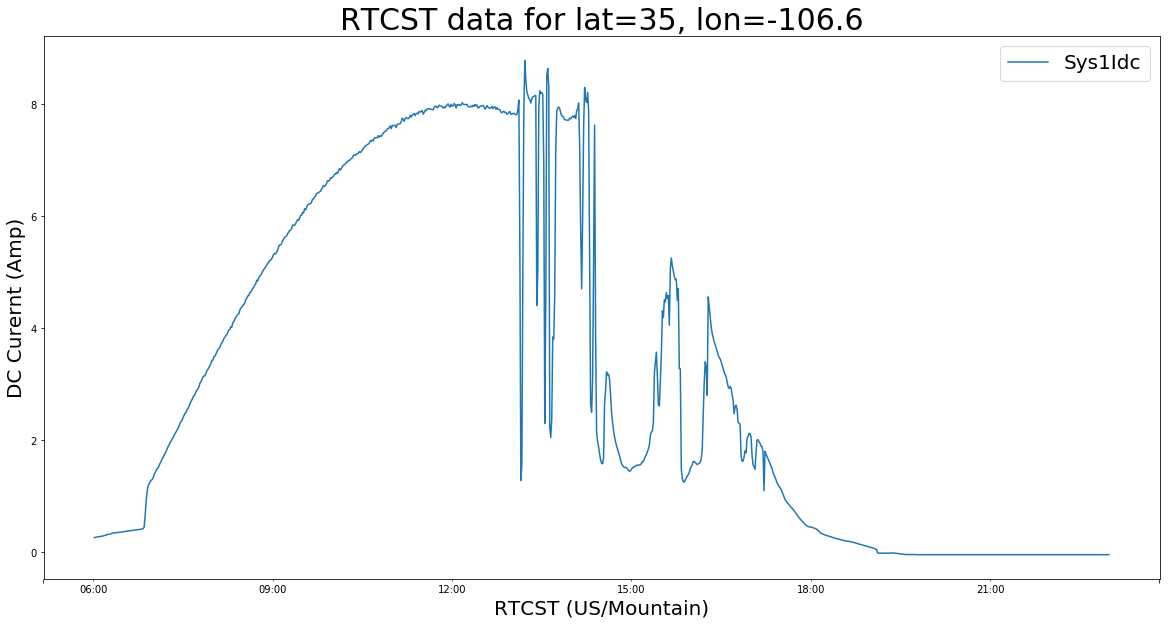

In [31]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

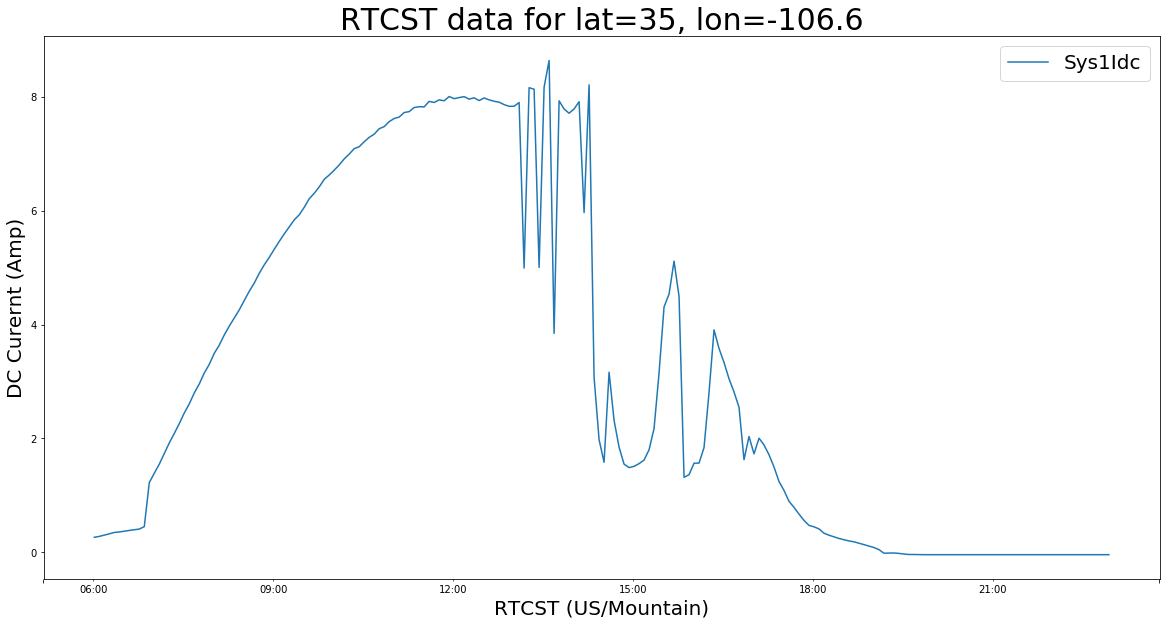

In [32]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

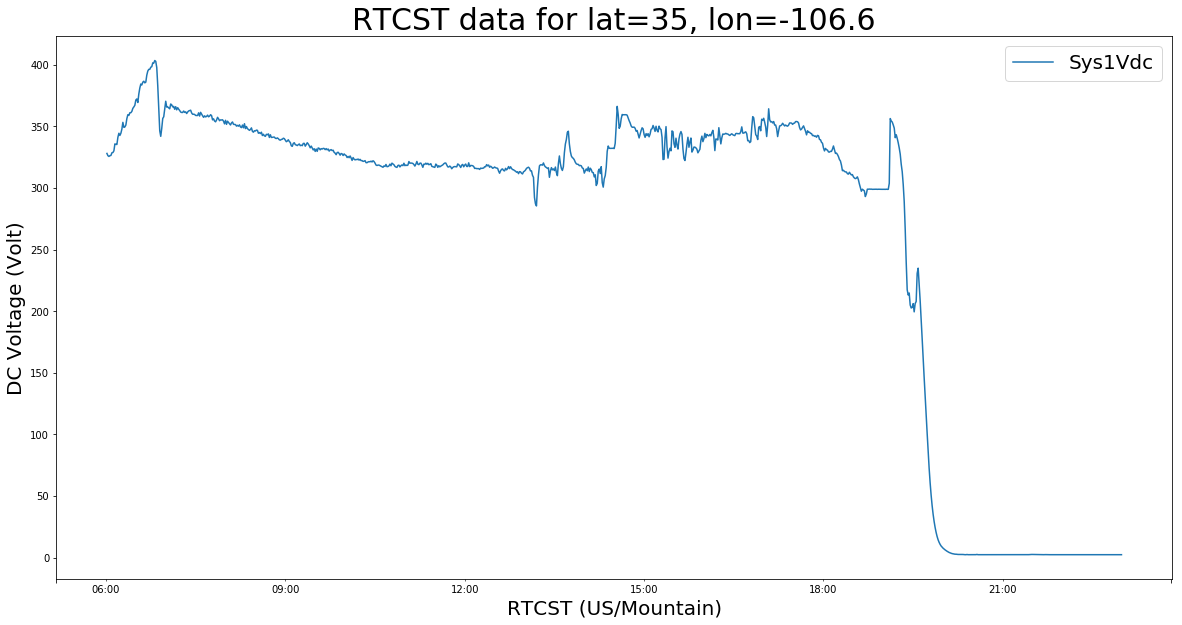

In [33]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

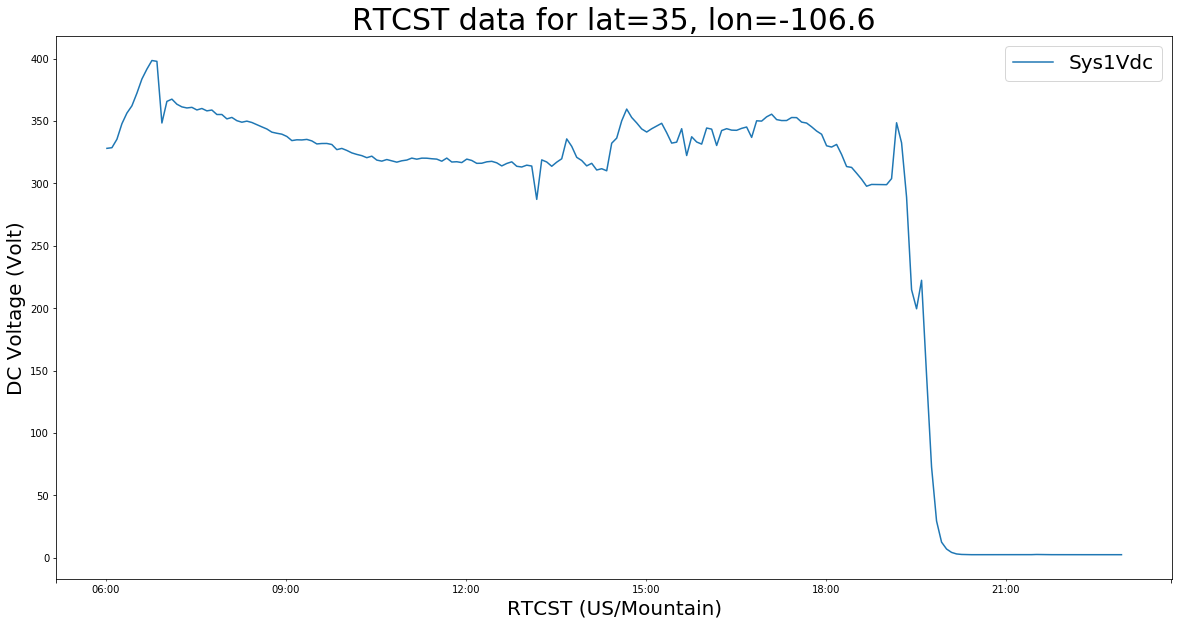

In [34]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df_slice[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## Read CSV's

In [35]:
# Read HRRR Irradiance CSV
hrrr_df = pd.read_csv('HRRR June 17.csv')
print("Keys of hrrr_df: \n{}".format(hrrr_df.keys()))

Keys of hrrr_df: 
Index(['Unnamed: 0', 'ghi', 'dni', 'dhi'], dtype='object')


In [36]:
hrrr_df.describe()

,ghi,dni,dhi
count,18.000000,18.000000,18.000000
mean,448.813224,445.091847,122.776514
std,384.525230,327.499738,99.057793
min,0.000000,0.000000,0.000000
25%,30.428942,22.352120,25.873809
50%,447.515933,651.443613,120.361851
75%,821.079932,716.100392,205.487691
max,974.504283,733.277977,279.676357


In [37]:
hrrr_df.head()

,Unnamed: 0,ghi,dni,dhi
0,2020-06-16 06:00:00-06:00,0.188081,0.000000,0.188081
1,2020-06-16 07:00:00-06:00,91.527380,89.408482,73.306849
2,2020-06-16 08:00:00-06:00,304.556343,473.105048,115.738019
3,2020-06-16 09:00:00-06:00,520.494835,678.720902,124.985683
4,2020-06-16 10:00:00-06:00,706.041614,732.441908,162.460858


In [38]:
# Read Forecast AC Power CSV
ac_df = pd.read_csv('AC June 17.csv')
print("Keys of ac_df: \n{}".format(ac_df.keys()))

Keys of ac_df: 
Index(['2020-06-16 06:00:00-06:00', '-1.56'], dtype='object')


In [39]:
ac_df.head()

,2020-06-16 06:00:00-06:00,-1.56
0,2020-06-16 06:05:00-06:00,-1.560000
1,2020-06-16 06:10:00-06:00,-1.560000
2,2020-06-16 06:15:00-06:00,-1.560000
3,2020-06-16 06:20:00-06:00,-8.924599
4,2020-06-16 06:25:00-06:00,25.683962


In [40]:
# TimeStamp as Index
ac_df.set_index('2020-06-16 06:00:00-06:00', inplace=True)
ac_df.head()

,-1.56
2020-06-16 06:00:00-06:00,
2020-06-16 06:05:00-06:00,-1.560000
2020-06-16 06:10:00-06:00,-1.560000
2020-06-16 06:15:00-06:00,-1.560000
2020-06-16 06:20:00-06:00,-8.924599
2020-06-16 06:25:00-06:00,25.683962


In [41]:
ac_df.rename(columns={'-1.56':'AC Power'}, inplace=True)
ac_df.head()

,AC Power
2020-06-16 06:00:00-06:00,
2020-06-16 06:05:00-06:00,-1.560000
2020-06-16 06:10:00-06:00,-1.560000
2020-06-16 06:15:00-06:00,-1.560000
2020-06-16 06:20:00-06:00,-8.924599
2020-06-16 06:25:00-06:00,25.683962


In [42]:
ac_df.describe()

,AC Power
count,204.000000
mean,1698.687986
std,1110.602875
min,-8.924599
25%,248.472738
50%,2359.087333
75%,2620.996940
max,2685.620084


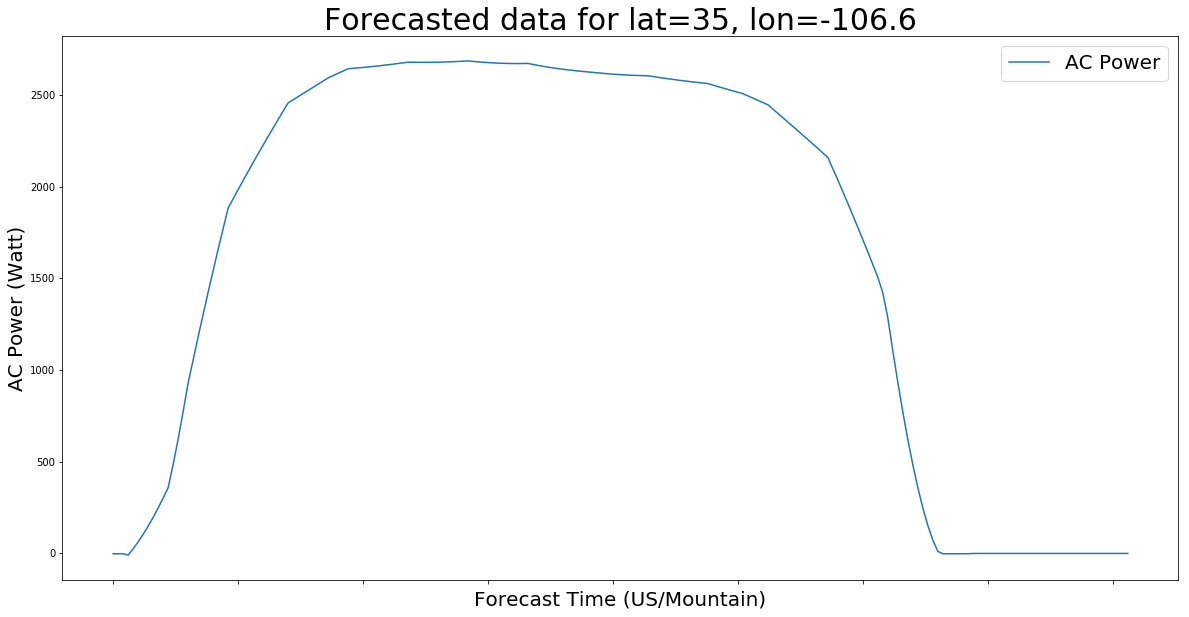

In [43]:
# Plot AC Power
forecast_ac = ['AC Power']
ac_df[forecast_ac].plot(figsize=(20,10), label = 'AC Power');
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Forecast Time ({})'.format(tz),size=20);
plt.title('Forecasted data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [44]:
# Read Forecast DC Power CSV
dc_df = pd.read_csv('DC June 17.csv')
print("Keys of dc_df: \n{}".format(dc_df.keys()))

Keys of dc_df: 
Index(['Unnamed: 0', 'i_sc', 'i_mp', 'v_oc', 'v_mp', 'p_mp', 'i_x', 'i_xx'], dtype='object')


In [45]:
dc_df.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,3.131298,2.787950,651.277158,515.283323,1793.756906,3.059018,2.001444
std,2.037652,1.811057,313.036098,252.624889,1164.101413,1.991313,1.283412
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.588782,0.532000,765.342142,618.255416,337.302143,0.573655,0.419336
50%,4.345234,3.867423,800.060379,633.363716,2483.220620,4.244603,2.786559
75%,4.863890,4.324336,818.671059,651.747094,2760.653675,4.752988,3.070434
max,4.915057,4.370221,825.170476,679.644044,2830.134671,4.803143,3.098397


In [46]:
dc_df.head()

,Unnamed: 0,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
0,2020-06-16 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-06-16 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-06-16 06:10:00-06:00,0.006229,0.005639,561.081398,54.256352,0.305942,0.006066,0.004505
3,2020-06-16 06:15:00-06:00,0.085353,0.077254,694.146901,461.995798,35.690831,0.083130,0.061611
4,2020-06-16 06:20:00-06:00,0.152973,0.138428,723.150429,527.576304,73.031224,0.148998,0.110224


### Merge DataFrames

In [47]:
# Clear Index
ac_df=ac_df.reset_index()
system_df_slice=system_df_slice.reset_index()

In [48]:
ac_df.head()

,2020-06-16 06:00:00-06:00,AC Power
0,2020-06-16 06:05:00-06:00,-1.560000
1,2020-06-16 06:10:00-06:00,-1.560000
2,2020-06-16 06:15:00-06:00,-1.560000
3,2020-06-16 06:20:00-06:00,-8.924599
4,2020-06-16 06:25:00-06:00,25.683962


In [49]:
ac_df.describe()

,AC Power
count,204.000000
mean,1698.687986
std,1110.602875
min,-8.924599
25%,248.472738
50%,2359.087333
75%,2620.996940
max,2685.620084


In [50]:
system_df_slice.head()

,TimeStamp,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
0,2020-06-16 06:01:00,21.875000,46.349934,36.770126,35.734722,0.2635,328.133331,73.055222,0.29950,351.333344,79.643280
1,2020-06-16 06:06:00,22.183332,40.556198,38.319809,37.258770,0.2790,328.666656,77.926704,0.30325,358.733307,86.870537
2,2020-06-16 06:11:00,22.133333,42.487446,40.634830,38.719505,0.3005,335.416656,87.642815,0.32725,361.166656,95.407135
3,2020-06-16 06:16:00,22.816666,55.813049,47.534805,43.554813,0.3240,347.883301,99.678986,0.37150,363.933319,112.873894
4,2020-06-16 06:21:00,22.616667,78.601768,44.138714,44.348064,0.3480,356.416656,110.325600,0.43075,366.116669,134.243179


In [51]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,27.803349,399.397123,386.491875,383.854924,3.161621,268.481366,984.818097,3.190942,269.548196,1015.128679
std,2.744528,377.511822,374.593154,374.796527,3.090203,131.021759,936.816413,3.068544,136.372314,953.934535
min,21.875000,-3.476246,0.000000,0.000000,-0.042250,2.400000,-2.790799,0.006000,1.566667,0.000000
25%,25.727082,25.782153,26.557075,26.196659,0.178062,303.762497,34.986243,0.204875,314.662476,44.707595
50%,28.470832,283.700256,247.262497,241.237556,1.990750,322.333328,663.879181,2.008750,327.424988,688.765564
75%,30.102084,776.578751,771.347763,762.022888,6.332062,343.966660,2005.553131,6.349687,351.354172,2043.402527
max,32.500000,1083.816040,1060.982300,1066.247314,8.636500,398.549957,2622.957764,8.674000,370.633331,2682.318848


In [52]:
# I guess it will make plotting easier
system=system_df_slice['Sys1Wac']
ac_df['System']=system
ac_df.head()

,2020-06-16 06:00:00-06:00,AC Power,System
0,2020-06-16 06:05:00-06:00,-1.560000,73.055222
1,2020-06-16 06:10:00-06:00,-1.560000,77.926704
2,2020-06-16 06:15:00-06:00,-1.560000,87.642815
3,2020-06-16 06:20:00-06:00,-8.924599,99.678986
4,2020-06-16 06:25:00-06:00,25.683962,110.325600


In [53]:
# TimeStamp as Index
ac_df.set_index('2020-06-16 06:00:00-06:00', inplace=True)
ac_df.head()

,AC Power,System
2020-06-16 06:00:00-06:00,,
2020-06-16 06:05:00-06:00,-1.560000,73.055222
2020-06-16 06:10:00-06:00,-1.560000,77.926704
2020-06-16 06:15:00-06:00,-1.560000,87.642815
2020-06-16 06:20:00-06:00,-8.924599,99.678986
2020-06-16 06:25:00-06:00,25.683962,110.325600


In [54]:
# Examine the column labels
all(isinstance(column, str) for column in ac_df.columns)

True

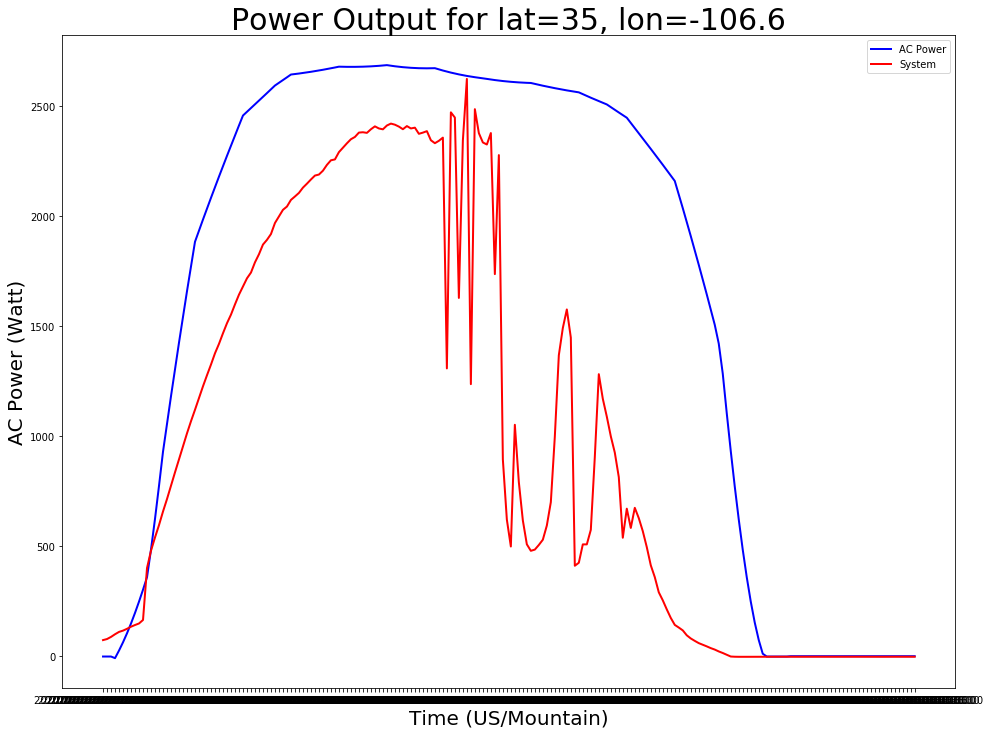

In [55]:
plt.figure(figsize=(16,12))
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Time ({})'.format(tz),size=20);
plt.title('Power Output for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.plot('AC Power', data=ac_df, marker='', color='blue', linewidth=2);
plt.plot('System', data=ac_df, marker='', color='red', linewidth=2);
plt.legend();

## Error
### Mean Square Error

In [56]:
y_true= system_df_slice['Sys1Wac']
y_pred= ac_df['AC Power']
print('Mean Square Error:\n',mean_squared_error(y_true, y_pred))

Mean Square Error:
 1021957.7421403413
